# santa, normal 이진 분류
- binary classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import gc
import random
from PIL import Image

import torch
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import torchvision.models as models
import timm

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

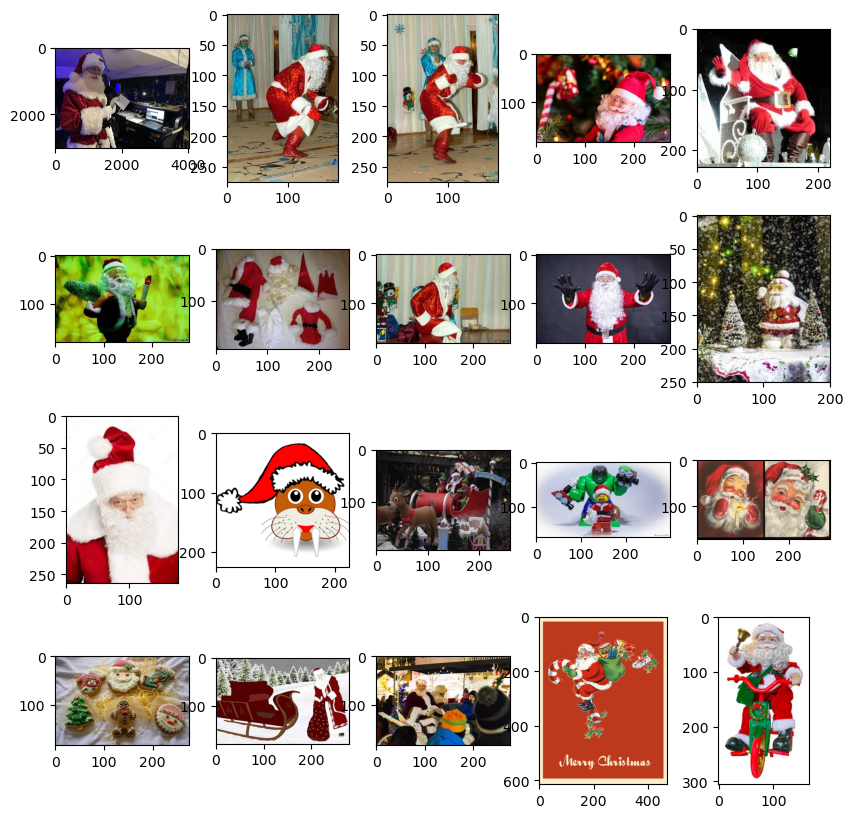

In [3]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(Image.open(f'/Users/kimhongseok/cv_79_projects/part1/chapter1/4/data/train/santa/{i}.Santa.jpg').convert('RGB'))

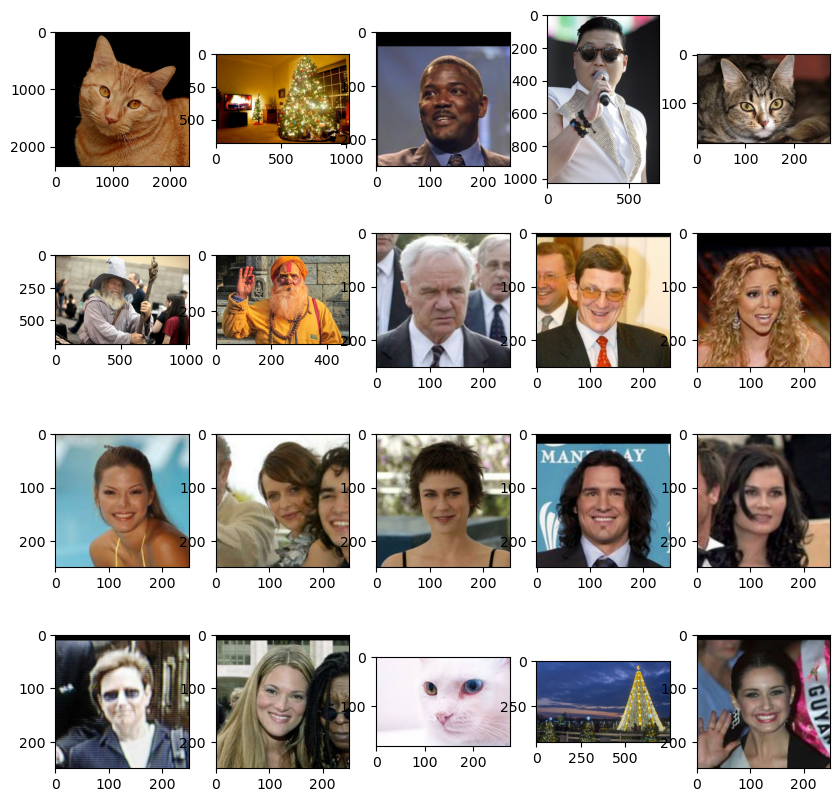

In [4]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(Image.open(f'/Users/kimhongseok/cv_79_projects/part1/chapter1/4/data/train/normal/{i}.not-a-santa.jpg').convert('RGB'))

# CustomDataset

## class 생성

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, classes, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i, cls in enumerate(classes):
            cls_path = os.path.join(root_dir, cls)
            img_list = os.listdir(cls_path)
            
            for img in img_list:
                if img != '.DS_Store':
                    self.data.append((os.path.join(cls_path, img), i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [6]:
classes = ['santa', 'normal']

transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

train_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/4/data/train', classes, transforms)
valid_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/4/data/val', classes, transforms)
test_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/4/data/test', classes, transforms)

In [7]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

895 267 68


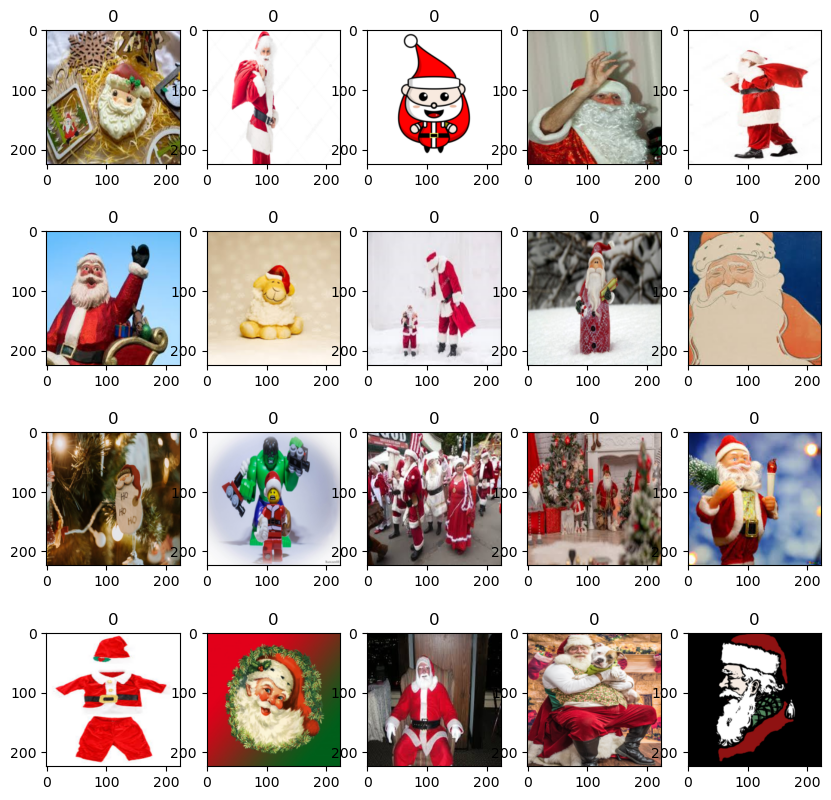

In [8]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(train_dataset[i][0].permute(1, 2, 0))
    plt.title(train_dataset[i][1])

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

## ImageFolder 사용하는 방법

In [10]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

train_dataset = ImageFolder('/Users/kimhongseok/cv_79_projects/part1/chapter1/4/data/train', transforms)
valid_dataset = ImageFolder('/Users/kimhongseok/cv_79_projects/part1/chapter1/4/data/val', transforms)
test_dataset = ImageFolder('/Users/kimhongseok/cv_79_projects/part1/chapter1/4/data/test', transforms)

# Train, Evaluation

In [10]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(probs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, optimizer, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(probs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    train_accuracy_list = []
    train_loss_list = []
    valid_accuracy_list = []
    valid_loss_list = []

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, optimizer, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(train_loss)
        valid_accuracy_list.append(valid_accuracy)
        valid_loss_list.append(valid_loss)

    return model, train_accuracy_list, train_loss_list, valid_accuracy_list, valid_loss_list

# model

In [11]:
model = timm.create_model(
    'vgg19',
    pretrained=True,
    num_classes=2
)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, train_accuracy_list, train_loss_list, valid_accuracy_list, valid_loss_list = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 5)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 1.5359899742262704, Train Accuracy: 0.5463687150837989, Valid Loss: 0.5730322139228091, Valid Accuracy: 0.5131086142322098


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.7009508897151265, Train Accuracy: 0.7094972067039106, Valid Loss: 0.7068579442360822, Valid Accuracy: 0.50187265917603


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.7453271161232676, Train Accuracy: 0.6, Valid Loss: 0.3170566019766471, Valid Accuracy: 0.846441947565543


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.3481296721313681, Train Accuracy: 0.8446927374301676, Valid Loss: 0.24517156928777695, Valid Accuracy: 0.8838951310861424


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.29831258047904285, Train Accuracy: 0.8748603351955307, Valid Loss: 0.274067862507175, Valid Accuracy: 0.8689138576779026


Text(0.5, 1.0, 'Valid Accuracy')

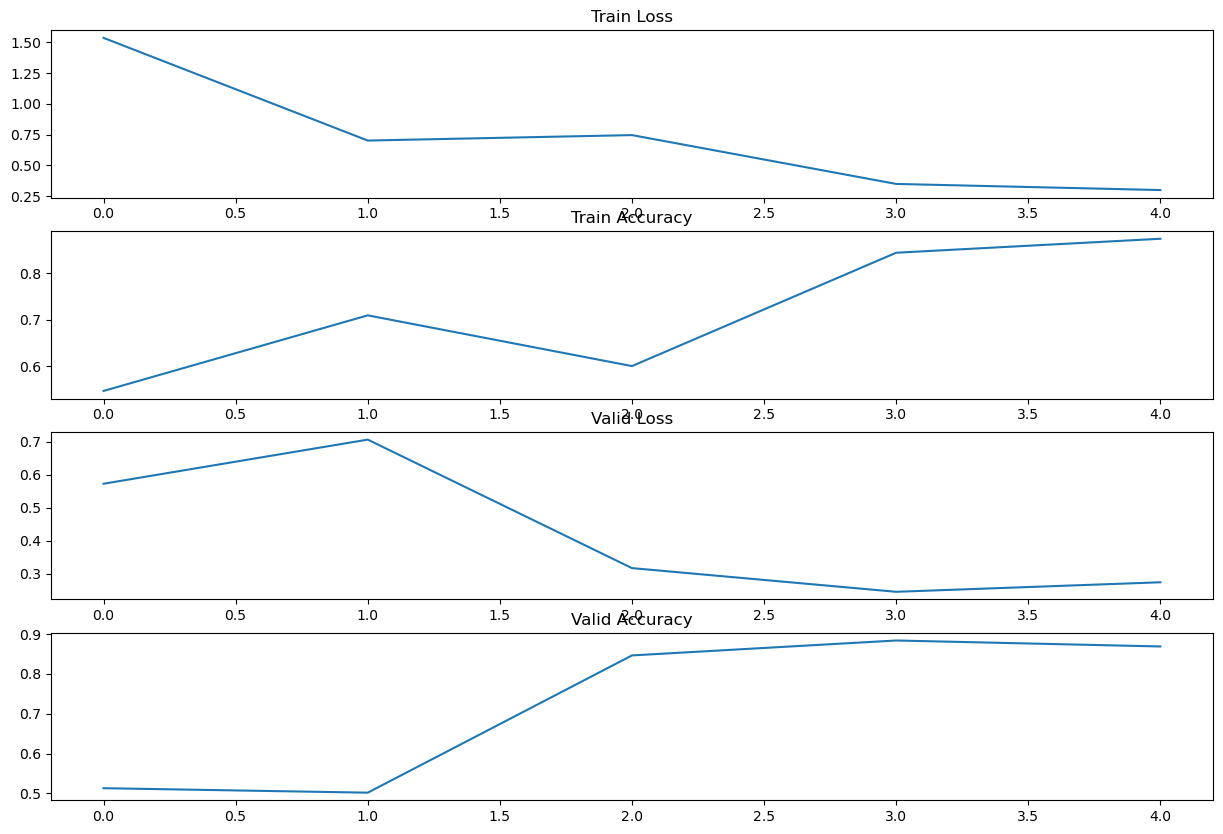

In [13]:
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(train_loss_list)
plt.title('Train Loss')

plt.subplot(4, 1, 2)
plt.plot(train_accuracy_list)
plt.title('Train Accuracy')

plt.subplot(4, 1, 3)
plt.plot(valid_loss_list)
plt.title('Valid Loss')

plt.subplot(4, 1, 4)
plt.plot(valid_accuracy_list)
plt.title('Valid Accuracy')

# test

In [14]:
model.eval()
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        max_prob, preds = torch.max(probs, 1)
        total_preds.extend(preds)

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
total_preds[0]

tensor(0, device='mps:0')

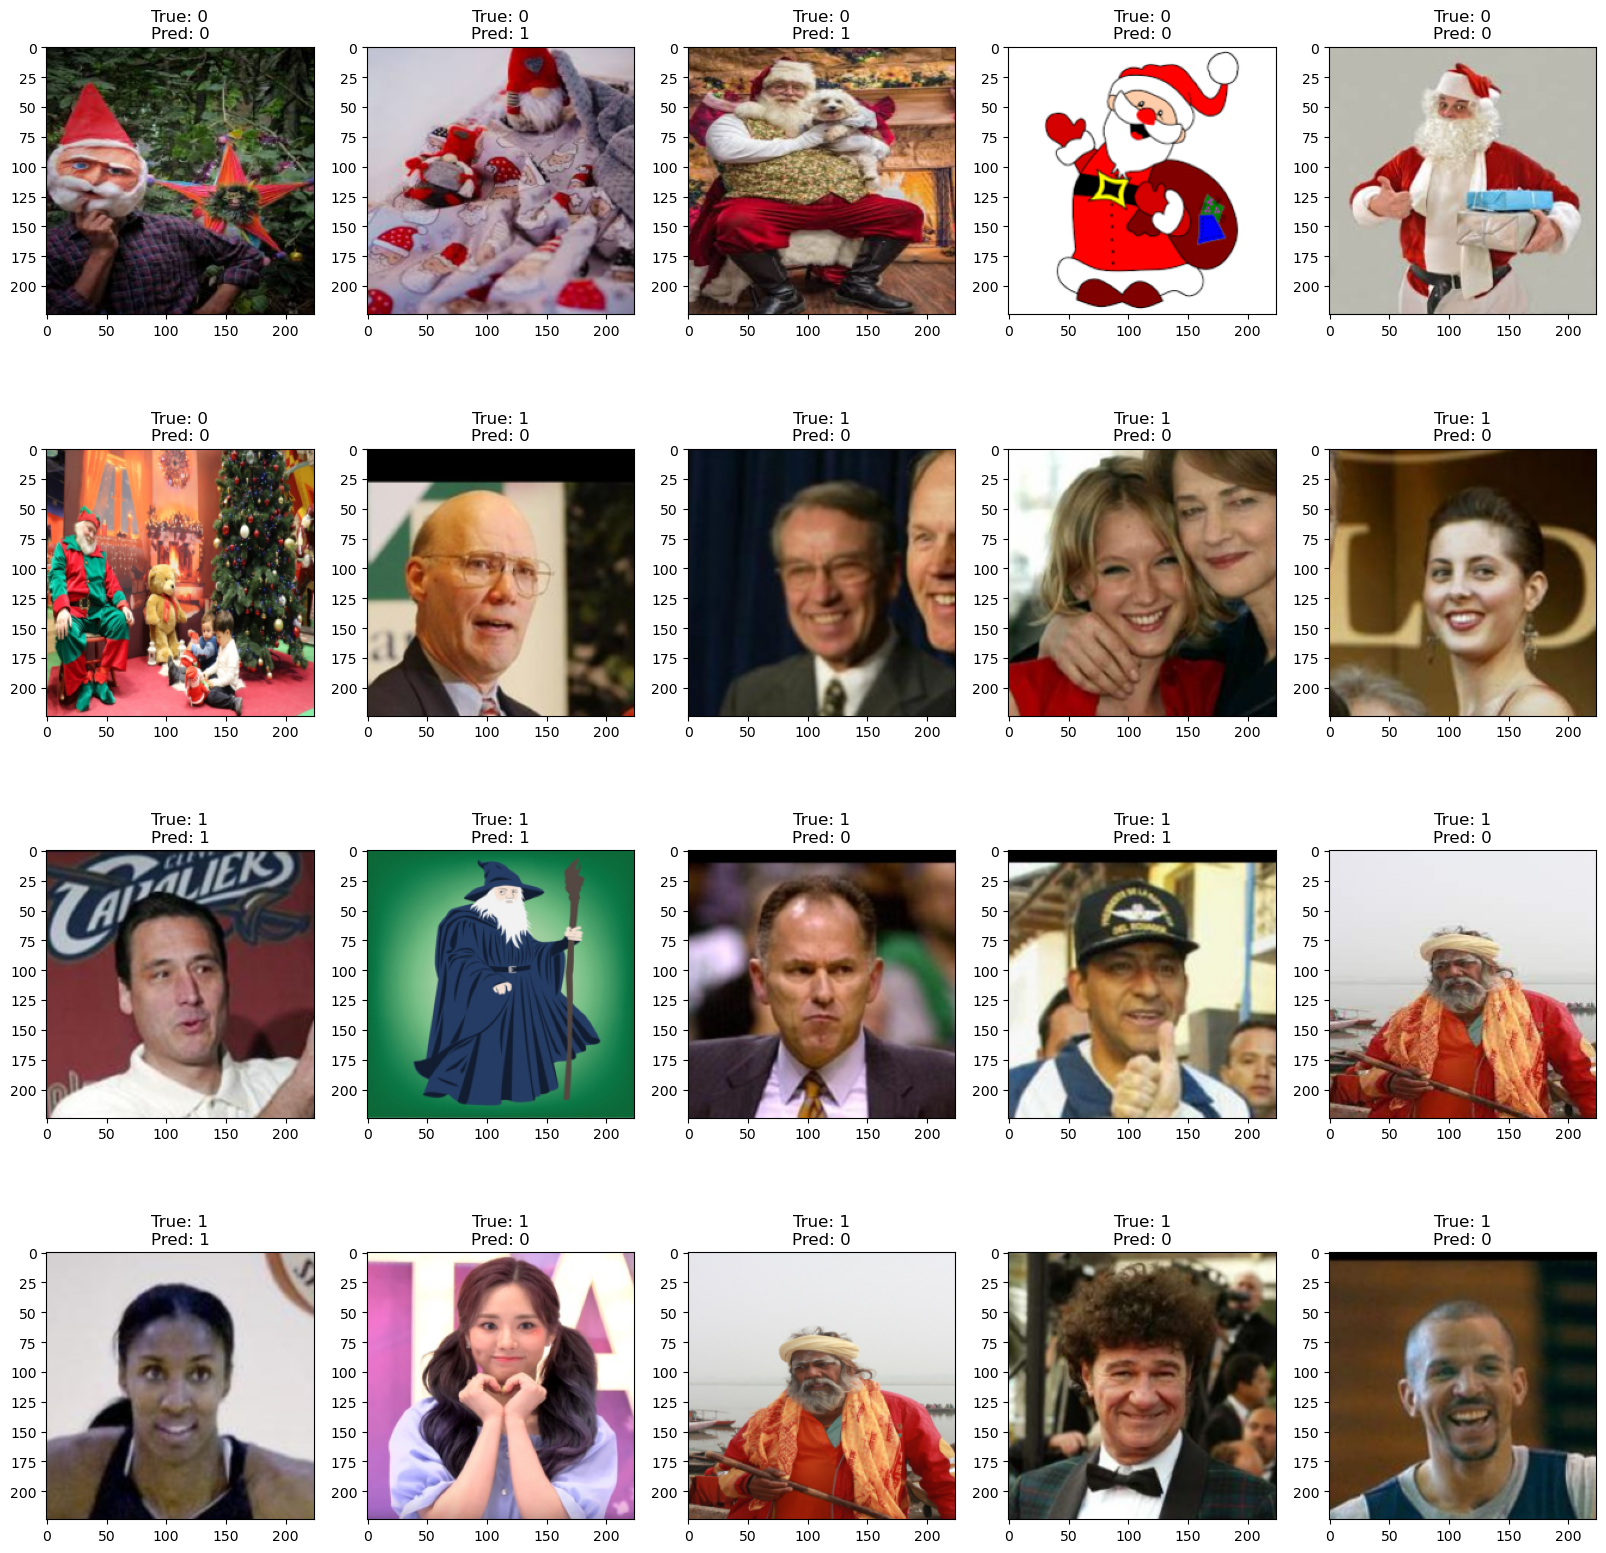

In [20]:
plt.figure(figsize=(20, 20))

for i in range(30, 50):
    ax = plt.subplot(4, 5, (i%30)+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {test_dataset[i][1]}\nPred: {total_preds[i].cpu().item()}')